In [2]:
import networkx as nx
import pybnb

In [3]:
from iterative_mis.visualize_graph import *
from iterative_mis.utils import *
from iterative_mis.MIS_kernel import PulserMISSolver
from iterative_mis.BB_kernel import BBQ_MIS

## PCI graph coloring problem
Start from an initial graph G=(V, E), whose vertexes' positions are given. The conflicts between vertexes correspond to conflicts between antennas, the maximum distance at which a conflict can appear is set to 100km.
The straightforward embedding on the Pasqal machine is obtained through scaling the initial positions into a circle with a maximum radius of 50 μm.

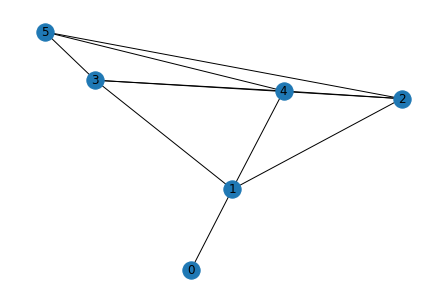

In [4]:
# read graph
num_vertexes = 6
G = nx.read_gpickle("graphs_dataset/G_{}.gpickle".format(num_vertexes))
G = plot_initial_graph_nx(G, num_vertexes)
orig_G = G.copy()

Blockade Radius 26.95 μm


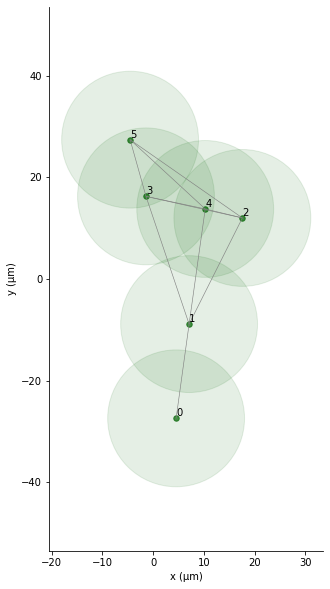

In [5]:
# pulser embedding
rabi_freq, blockade_radius = compute_rydberg(G)
print(f'Blockade Radius {blockade_radius:.2f} μm')
plot_initial_graph_pulser(G, blockade_radius)

## Greedy-itMIS
Solve iteratively MIS (Maximum Independent Set) problem to retrieve a feasible coloring. At each step, a subset of independent vertexes is removed from G and a color is assigned to them.

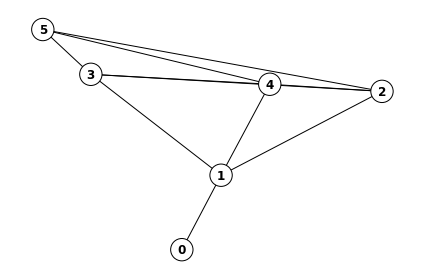

Found 44 solutions
Found MIS solution at position 27


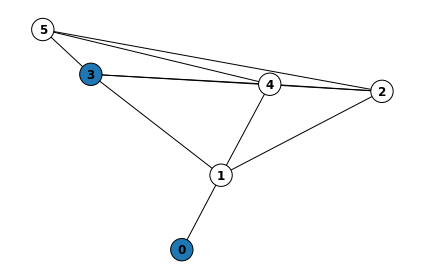

Found 15 solutions
Found MIS solution at position 2


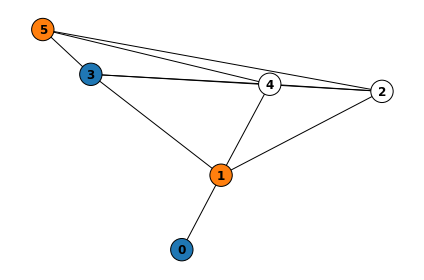

Found 3 solutions
Found MIS solution at position 0


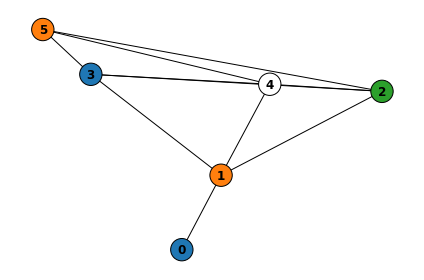

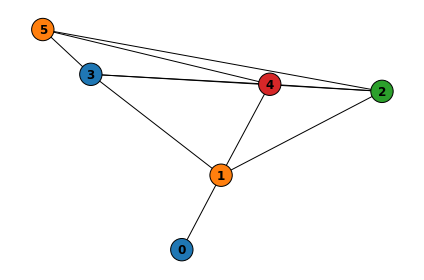

Iterative MIS solved with 4 colors


In [6]:
coloring =  dict.fromkeys(G.nodes(), -1)
num_colors = 0

# plot initial graph
plot_sol(coloring, orig_G, -1)

while len(G.nodes())> 0:   
    if len(G.edges())>0: 
        # there are still conflict to be solved
        pulser_MIS_solver = PulserMISSolver(G)
        # solve MIS
        solutions = pulser_MIS_solver.solve_Pulser()
        num_sol = len(solutions)     
        print('Found {} solutions'.format(num_sol))       
        for sol in range(num_sol):  
            x = solutions[sol]      
            if is_MIS(x, G):
                # the solution is indipendent and maximal
                H, MIS_set = compute_subgraph(x, G)
                print(f'Found MIS solution at position {sol}')
                break
        G=H
    else:
        # the same color can be assigned to all the remaining nodes 
        MIS_set=G.nodes()
        G = G.subgraph([])
    num_colors+=1
    # update the coloring
    for graph_node in MIS_set:
        coloring[graph_node]=num_colors 
    # plot coloring
    plot_sol(coloring.copy(), orig_G, num_colors)
        
print('Iterative MIS solved with {} colors'.format(num_colors))  

In [7]:
# compare coloring results with the one obtained with different nx heuristics
NetworkxGC(orig_G)

Networkx solution with largest_first strategy uses 4 colors
Networkx solution with random_sequential strategy uses 4 colors
Networkx solution with smallest_last strategy uses 4 colors
Networkx solution with independent_set strategy uses 4 colors
Networkx solution with connected_sequential_bfs strategy uses 4 colors
Networkx solution with connected_sequential_dfs strategy uses 4 colors
Networkx solution with saturation_largest_first strategy uses 4 colors


## BB-itMIS
Introduce an outer optimization loop: the Branch&Bound procedure allows exploring different MIS candidate solutions, thus increasing the chance of selecting vertices' subset corresponding to an optimal graph coloring. 


Using non-default solver options:
 - node_limit: 20 (default: None)
 - queue_strategy: custom (default: bound)

Starting branch & bound solve:
 - dispatcher pid: 312 (LAPTOP-SIDQI55K)
 - worker processes: 1
--------------------------------------------------------------------------------------------------------------------------
         Nodes        |                      Objective Bounds                       |              Work              
      Expl    Unexpl  |      Incumbent           Bound    Rel. Gap         Abs. Gap | Time (s)  Nodes/Sec Imbalance   Idle
         0         1  |            inf            -inf         inf%             inf |      0.0       0.00     0.00%      0
         1         4  |            inf               4         inf%             inf |     56.6       0.02     0.00%      0
*        2         3  |              5               4   20.000000%               1 |     87.8       0.03     0.00%      0
*        3         0  |              4               4    0

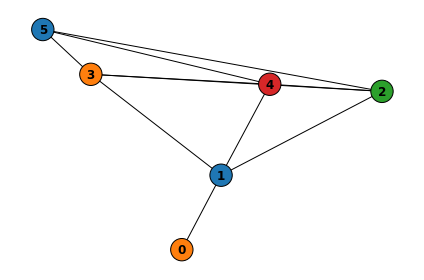

Coloring story {0: -1, 1: 1, 2: 1}
{0: 2, 1: 1, 2: 3, 3: 2, 4: 4, 5: 1}
BB found coloring with 4 colors


In [8]:
problem = BBQ_MIS(orig_G)
solver = pybnb.Solver()
results = solver.solve(problem, queue_strategy='custom', node_limit=20)
best_coloring = results.best_node.state[4]
child_story = results.best_node.state[5]
problem.plot_sol(best_coloring, results.objective)
print('Coloring story {}'.format(child_story))
print(best_coloring)
print('BB found coloring with {} colors'.format(results.objective))
